In [3]:
import os

# Set JAVA_HOME explicitly in notebook
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@17"
os.environ["PATH"] = f'{os.environ["JAVA_HOME"]}/bin:' + os.environ["PATH"]

# import spark and spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .appName("career_df")\
    .getOrCreate()
sc= spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/28 06:49:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load and display the data
career_df = spark.read.option("header", True).csv("../Data/raw/field_of_study_vs_occupation.csv")
career_df.show()

# Show the data schema
career_df.printSchema()

+--------------------+------------------+---+------+-------------------+---------------+--------------------+----------------+-----------------+-----------------+------+------------+----------------------+----------+----------------+--------------------+--------------+----------------------+-------------------+---------------------+--------------------+-------------------+---------------------------+
|      Field of Study|Current Occupation|Age|Gender|Years of Experience|Education Level|Industry Growth Rate|Job Satisfaction|Work-Life Balance|Job Opportunities|Salary|Job Security|Career Change Interest|Skills Gap|Family Influence|Mentorship Available|Certifications|Freelancing Experience|Geographic Mobility|Professional Networks|Career Change Events|Technology Adoption|Likely to Change Occupation|
+--------------------+------------------+---+------+-------------------+---------------+--------------------+----------------+-----------------+-----------------+------+------------+----------

In [5]:
# Count the number of null values per column
from pyspark.sql.functions import col, sum, when

null_counts = career_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in career_df.columns])

null_counts.show()

# Show summary stats of the data
career_df.describe().show()

+--------------+------------------+---+------+-------------------+---------------+--------------------+----------------+-----------------+-----------------+------+------------+----------------------+----------+----------------+--------------------+--------------+----------------------+-------------------+---------------------+--------------------+-------------------+---------------------------+
|Field of Study|Current Occupation|Age|Gender|Years of Experience|Education Level|Industry Growth Rate|Job Satisfaction|Work-Life Balance|Job Opportunities|Salary|Job Security|Career Change Interest|Skills Gap|Family Influence|Mentorship Available|Certifications|Freelancing Experience|Geographic Mobility|Professional Networks|Career Change Events|Technology Adoption|Likely to Change Occupation|
+--------------+------------------+---+------+-------------------+---------------+--------------------+----------------+-----------------+-----------------+------+------------+----------------------+-----

25/07/28 06:49:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------+------------------+------------------+------+-------------------+---------------+--------------------+-----------------+-----------------+------------------+------------------+------------------+----------------------+-----------------+----------------+--------------------+-------------------+----------------------+-------------------+---------------------+--------------------+-------------------+---------------------------+
|summary|Field of Study|Current Occupation|               Age|Gender|Years of Experience|Education Level|Industry Growth Rate| Job Satisfaction|Work-Life Balance| Job Opportunities|            Salary|      Job Security|Career Change Interest|       Skills Gap|Family Influence|Mentorship Available|     Certifications|Freelancing Experience|Geographic Mobility|Professional Networks|Career Change Events|Technology Adoption|Likely to Change Occupation|
+-------+--------------+------------------+------------------+------+-------------------+-----

In [6]:
# Cast the numerical columns to the integer datatype
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# Numerical columns
int_cols = [
    "Age", "Years of Experience", "Job Satisfaction", "Work-Life Balance",
    "Job Opportunities", "Salary", "Job Security", "Career Change Interest",
    "Skills Gap", "Mentorship Available", "Certifications", "Freelancing Experience",
    "Geographic Mobility", "Professional Networks", "Career Change Events",
    "Technology Adoption", "Likely to Change Occupation"
]

# Apply casting
for col_name in int_cols:
    career_df= career_df.withColumn(col_name, col(col_name).cast(IntegerType()))

# Show the updated schema
career_df.printSchema()

root
 |-- Field of Study: string (nullable = true)
 |-- Current Occupation: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Years of Experience: integer (nullable = true)
 |-- Education Level: string (nullable = true)
 |-- Industry Growth Rate: string (nullable = true)
 |-- Job Satisfaction: integer (nullable = true)
 |-- Work-Life Balance: integer (nullable = true)
 |-- Job Opportunities: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Job Security: integer (nullable = true)
 |-- Career Change Interest: integer (nullable = true)
 |-- Skills Gap: integer (nullable = true)
 |-- Family Influence: string (nullable = true)
 |-- Mentorship Available: integer (nullable = true)
 |-- Certifications: integer (nullable = true)
 |-- Freelancing Experience: integer (nullable = true)
 |-- Geographic Mobility: integer (nullable = true)
 |-- Professional Networks: integer (nullable = true)
 |-- Career Change Events: integer

In [7]:
# Save the data with the new datatype as a parquet and csv file in the firstdeproj directory
career_df.write.mode("overwrite").parquet("../Data/clean/career_df.parquet")
career_df.write.option("header", True).mode("overwrite").csv("../Data/clean/career_df.csv")
career_df.toPandas().to_csv("../Data/clean/career_df2.csv", index=False)

In [8]:
# Count the number of people likely to change occupation or not
career_df.groupBy("Likely to Change Occupation")\
    .count()\
    .show()

+---------------------------+-----+
|Likely to Change Occupation|count|
+---------------------------+-----+
|                          1|22165|
|                          0|16279|
+---------------------------+-----+



+--------------------+---------------------+--------------------------------+
|      Field of Study|Total People in Field|Total Job Opportunities in Field|
+--------------------+---------------------+--------------------------------+
|            Business|                 3921|                          198857|
|           Education|                 3896|                          197733|
|            Medicine|                 3949|                          197435|
|                 Law|                 3851|                          197272|
|             Biology|                 3921|                          197146|
|Mechanical Engine...|                 3875|                          191244|
|    Computer Science|                 3826|                          190506|
|                Arts|                 3763|                          188812|
|           Economics|                 3743|                          188347|
|          Psychology|                 3699|                    

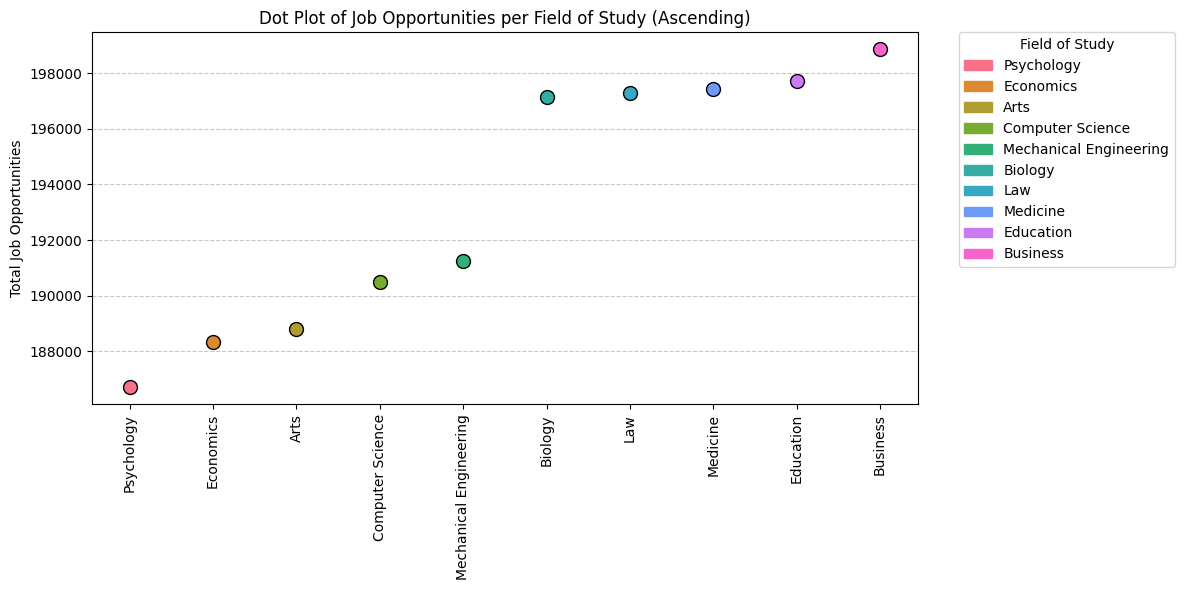

In [10]:
# Calculate the total number of job opportunities in each field of study
from pyspark.sql.functions import col, sum, count
import pandas as pd

opp_field_df = career_df.groupBy("Field of Study")\
    .agg(
        count("*").alias("Total People in Field"),
        sum("Job Opportunities").alias("Total Job Opportunities in Field")
    )\
    .orderBy(col("Total Job Opportunities in Field").desc())

# Display the fields of study with the highest total job opportunities
opp_field_df.show()
# Convert to Pandas DataFrame for plotting
opp_field = opp_field_df.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Sort by Total Job Opportunities (ascending order)
agg_pd_sorted = opp_field.sort_values(by="Total Job Opportunities in Field", ascending=True)

# Create unique color per field
fields = agg_pd_sorted["Field of Study"].tolist()
palette = sns.color_palette("husl", len(fields))
color_dict = dict(zip(fields, palette))

# Plot
plt.figure(figsize=(12, 6))
for i, field in enumerate(fields):
    plt.scatter(
        x=field,
        y=agg_pd_sorted.iloc[i]["Total Job Opportunities in Field"],
        color=color_dict[field],
        s=100,
        edgecolors='black'
    )

plt.xticks(rotation=90)
plt.ylabel("Total Job Opportunities")
plt.title("Dot Plot of Job Opportunities per Field of Study (Ascending)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Legend handles
legend_handles = [Patch(color=color_dict[field], label=field) for field in fields]

# Add legend on the right
plt.legend(
    handles=legend_handles,
    title="Field of Study",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()
plt.show()




+--------------------+---------------------+-----------------------+------------------------+
|      Field of Study|Total People in Field|People Likely to Change|Percent Likely to Change|
+--------------------+---------------------+-----------------------+------------------------+
|            Medicine|                 3949|                   2359|                   59.74|
|Mechanical Engine...|                 3875|                   2278|                   58.79|
|                 Law|                 3851|                   2239|                   58.14|
|           Education|                 3896|                   2255|                   57.88|
|                Arts|                 3763|                   2170|                   57.67|
|           Economics|                 3743|                   2150|                   57.44|
|             Biology|                 3921|                   2246|                   57.28|
|            Business|                 3921|                

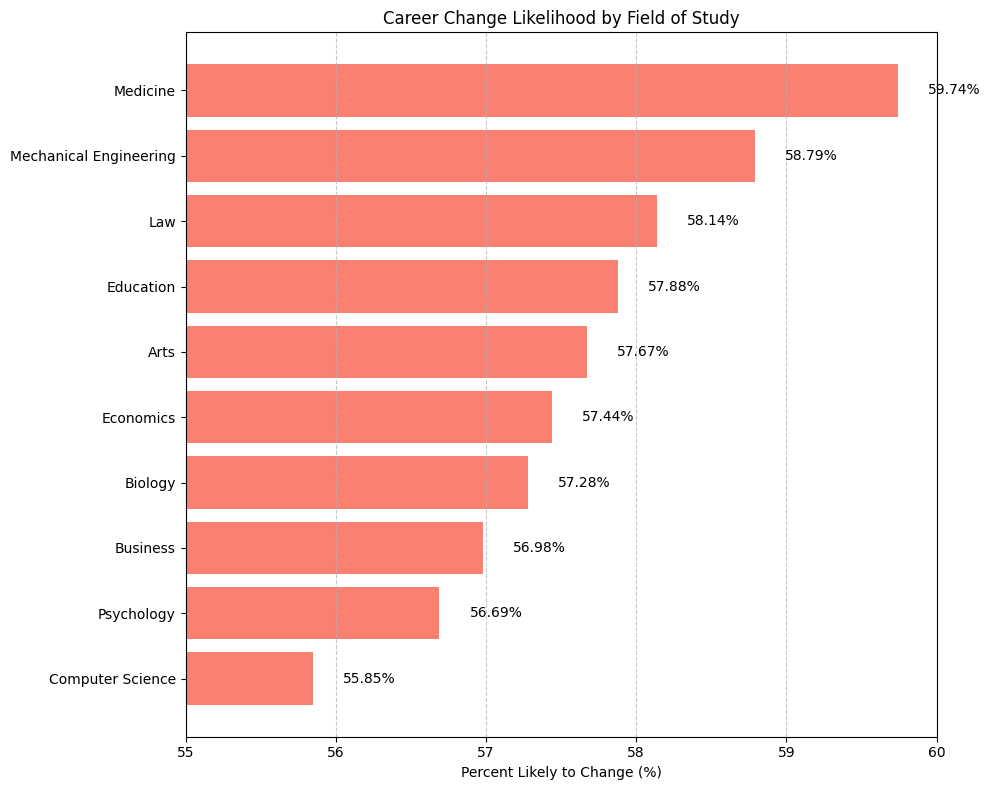

In [11]:
# Calculate the percentage of people likely to change occupation in each field of study and order the fields by the highest percentage.
from pyspark.sql.functions import count, sum, col, when, round, desc

per_change_df = career_df.groupBy("Field of Study")\
    .agg(
        count("*").alias("Total People in Field"),
        sum(when(col("Likely to Change Occupation") == 1, 1).otherwise(0)).alias("People Likely to Change")
    )\
    .withColumn("Percent Likely to Change", round(col("People Likely to Change") / col("Total People in Field") * 100, 2))\
    .orderBy(col("Percent Likely to Change").desc())
per_change_df.show()

# Convert to Pandas DataFrame for plotting
per_change_pd = per_change_df.toPandas()

# Sort for plotting
change_pd_sorted = per_change_pd.sort_values(by="Percent Likely to Change", ascending=True)

import matplotlib.pyplot as plt

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(
    change_pd_sorted["Field of Study"],
    change_pd_sorted["Percent Likely to Change"],
    color='salmon'
)

plt.xlabel("Percent Likely to Change (%)")
plt.title("Career Change Likelihood by Field of Study")

# Set X-axis range to focus between 50% and 60%
plt.xlim(55, 60)

# Optional: Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.2, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%", va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



+----------------+------------+-----------------------+------------------------+
|Family Influence|Total People|People Likely to Change|Percent Likely to Change|
+----------------+------------+-----------------------+------------------------+
|            None|        9632|                   5617|                   58.32|
|            High|        9635|                   5599|                   58.11|
|          Medium|        9618|                   5545|                   57.65|
|             Low|        9559|                   5404|                   56.53|
+----------------+------------+-----------------------+------------------------+



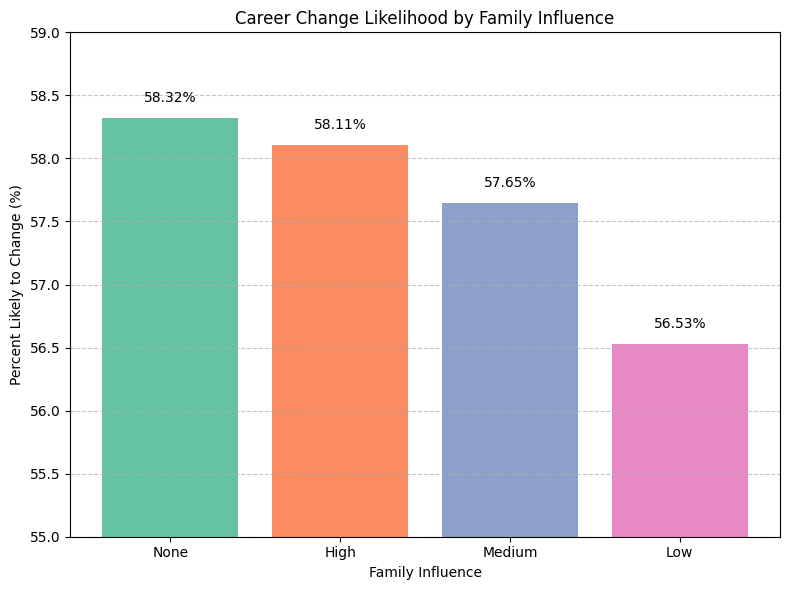

In [12]:
# Calculate the percentage of people likely to change occupation by family influence
from pyspark.sql.functions import count, sum, col, round, desc

fam_inf=career_df.groupBy("Family Influence")\
    .agg(
        count("*").alias("Total People"),
        sum(when(col("Likely to Change Occupation") == 1, 1).otherwise(0)).alias("People Likely to Change")
    )\
    .withColumn("Percent Likely to Change", round(col("People Likely to Change") / col("Total People") * 100, 2))\
    .orderBy(col("Percent Likely to Change").desc())

# Display the family influence data
fam_inf.show()

# Convert to pandas dataframe
fam_inf_pd = fam_inf.toPandas()


import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame if not already done
# fam_inf_pd = fam_inf.toPandas()

# Color palette (1 color per category)
palette = sns.color_palette("Set2", len(fam_inf_pd))

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(
    fam_inf_pd["Family Influence"],
    fam_inf_pd["Percent Likely to Change"],
    color=palette
)

# Add labels and styling
plt.ylabel("Percent Likely to Change (%)")
plt.xlabel("Family Influence")
plt.title("Career Change Likelihood by Family Influence")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Zoom in on Y-axis from 55% to 60%
plt.ylim(55, 59)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.1,  # small padding above the bar
        f"{yval:.2f}%",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


+--------------------+------------------------------------+-----------------------------------------------+------------------------------------------------+
|Career Change Events|Total People by Career Change Events|People Likely to Change by Career Change Events|Percent Likely to Change by Career Change Events|
+--------------------+------------------------------------+-----------------------------------------------+------------------------------------------------+
|                   2|                               12861|                                           7461|                                           58.01|
|                   0|                               12734|                                           7344|                                           57.67|
|                   1|                               12849|                                           7360|                                           57.28|
+--------------------+------------------------------------

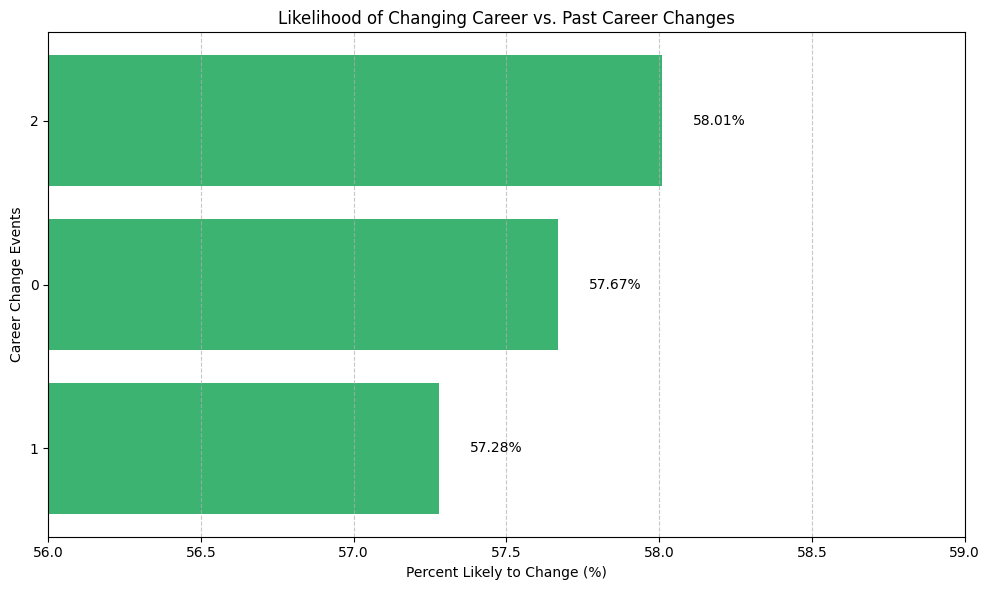

25/07/28 09:00:11 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 128432 ms exceeds timeout 120000 ms
25/07/28 09:00:11 WARN SparkContext: Killing executors is not supported by current scheduler.
25/07/28 09:00:12 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
# Calculate the percentage of people likely to change occupation by the number of times they have changed careers before
from pyspark.sql.functions import count, sum, col, when, round, desc

career_ev = career_df.groupBy("Career Change Events")\
    .agg(
        count("*").alias("Total People by Career Change Events"),
        sum(when(col("Likely to Change Occupation") == 1, 1).otherwise(0)).alias("People Likely to Change by Career Change Events")
    )\
    .withColumn("Percent Likely to Change by Career Change Events", round(col("People Likely to Change by Career Change Events") / col("Total People by Career Change Events") * 100, 2))\
    .orderBy(col("Percent Likely to Change by Career Change Events").desc())

# Display the career change events data
career_ev.show()

# Convert to pandas dataframe
career_ev_pd = career_ev.toPandas()

import matplotlib.pyplot as plt

# Sort for clean plotting
career_events_pd_sorted = career_ev_pd.sort_values(
    by="Percent Likely to Change by Career Change Events", ascending=True
)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    y=career_events_pd_sorted["Career Change Events"].astype(str),
    width=career_events_pd_sorted["Percent Likely to Change by Career Change Events"],
    color='mediumseagreen'
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%", va='center')

# Labels and styling
plt.xlabel("Percent Likely to Change (%)")
plt.ylabel("Career Change Events")
plt.title("Likelihood of Changing Career vs. Past Career Changes")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Set X-axis from 56 to 59
plt.xlim(56, 59)

plt.tight_layout()
plt.show()
